## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

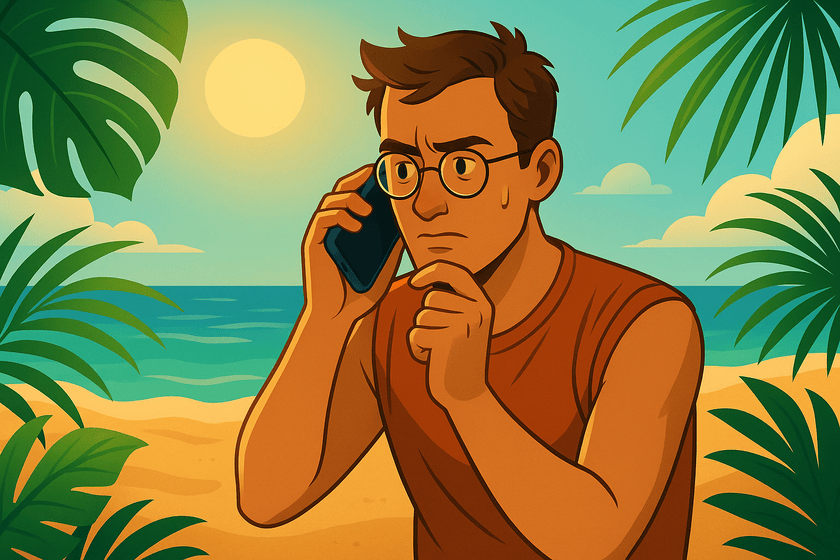

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


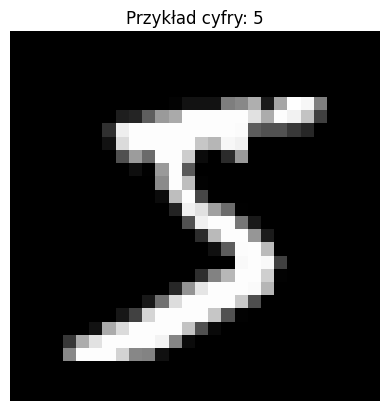

In [1]:
# ładowanie zbioru danych
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

#Ściąganie z '2. Wizja Komputerowa'

Pierwszym krokiem sobie dodam wszystkie niezbędne kawałki kodu z wykładu

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import time
import os
import random

SEED = 42 # he he 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#tu zależnie od resource jakie macie na collabie - darmowe jest CPU, ale można sobie dokupić zasoby obliczeniowe
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# transformacje: tensory + normalizacja (średnia/odchylenie MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# pobranie danych (zapisze do folderu ./data)
data_root = "./data"
train_full = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_ds    = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

# podział danych na train/val
val_size = 5000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128 # można zmienić na mniejszy - jeśli nie będzie działać (out of memory error), to TRZEBA zmienić na mniejszy (16,32,64)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 617kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.95MB/s]


(55000, 5000, 10000)

#Dodanie Baseline

Dodano jeszcze Baseline, napisałem go podobnie do SimpleNN z wykładu, z nim będę porównywać następne sieci i sprawdzę jak radzi sobie z zadaniem zwykła sieć

In [30]:
class BaselineNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Dodałem kod z wykładu i wyodrębniłem go funkcji żeby się nie powtarzać

In [34]:
from torch.optim import Adam

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5, device="cpu"):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    start = time.time()

    def run_epoch(loader, train: bool):
        epoch_loss, correct, total = 0.0, 0, 0
        if train:
            model.train()
        else:
            model.eval()
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            if train:
                optimizer.zero_grad()
            with torch.set_grad_enabled(train):
                logits = model(xb)
                loss = criterion(logits, yb)
                if train:
                    loss.backward()
                    optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
            preds = logits.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
        return epoch_loss / total, correct / total

    for epoch in range(1, epochs+1):
        tr_loss, tr_acc = run_epoch(train_loader, train=True)
        va_loss, va_acc = run_epoch(val_loader, train=False)
        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
        print(f"Ep {epoch:02d}/{epochs} | "
              f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
              f"val loss {va_loss:.4f} acc {va_acc:.4f}")

    print(f"Czas treningu: {time.time()-start:.1f}s")
    return history

In [35]:
def plot_history(history):
    plt.figure(figsize=(6,6))
    plt.plot(history["train_loss"], label="train loss")
    plt.plot(history["val_loss"], label="val loss")
    plt.xlabel("Epoka")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history["train_acc"], label="train acc")
    plt.plot(history["val_acc"], label="val acc")
    plt.xlabel("Epoka")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

W końcu sprawdzam jak radzi sobie model

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep 01/5 | train loss 0.3136 acc 0.9094 | val loss 0.1833 acc 0.9430
Ep 02/5 | train loss 0.1357 acc 0.9605 | val loss 0.1395 acc 0.9610
Ep 03/5 | train loss 0.0935 acc 0.9724 | val loss 0.1121 acc 0.9648
Ep 04/5 | train loss 0.0729 acc 0.9774 | val loss 0.1015 acc 0.9698
Ep 05/5 | train loss 0.0558 acc 0.9829 | val loss 0.0945 acc 0.9696
Czas treningu: 69.3s


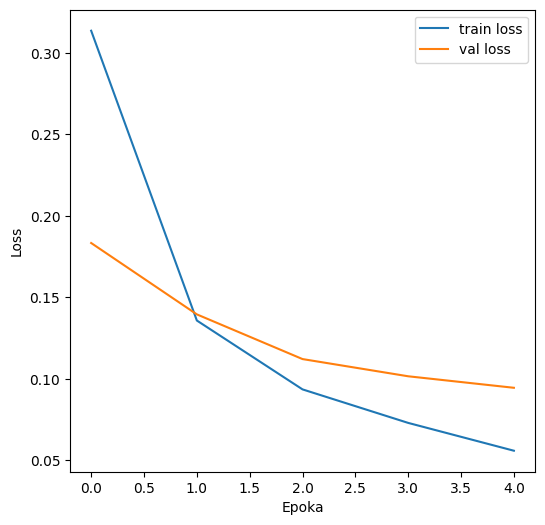

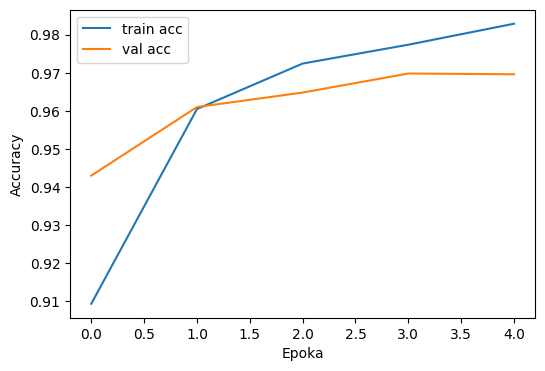

In [43]:
model = BaselineNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5, device=device)
plot_history(history)

Model na końcu ma 98.3% accuracy dla train i 96.9% dla val, co jest zgodnie z oczekiwaniamy bo MNIST nie jest trudnym datasetem. Będę się starał dalej otrzymać lepsze wyniki, dlatego pobieram model z wykładu.

#Własny model

On już ma nie tylko dwie warstwy, a jeszcze funkcja relu dla wprowadzania nieliniowości, MaxPool żeby skompresować dane i zostawić najważniejsze i Dropout żebu uniknąć overfitting

In [37]:
class FlexibleCNN(nn.Module):
    def __init__(self, num_classes=10, c1=32, c2=64, hidden=128, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv2d(1, c1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(c1, c2, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)

        self.fc1 = nn.Linear(c2 * 7 * 7, hidden)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [38]:
model = FlexibleCNN().to(device)

Ep 01/5 | train loss 0.2137 acc 0.9340 | val loss 0.0626 acc 0.9814
Ep 02/5 | train loss 0.0646 acc 0.9807 | val loss 0.0487 acc 0.9860
Ep 03/5 | train loss 0.0494 acc 0.9845 | val loss 0.0388 acc 0.9878
Ep 04/5 | train loss 0.0406 acc 0.9868 | val loss 0.0347 acc 0.9898
Ep 05/5 | train loss 0.0345 acc 0.9889 | val loss 0.0271 acc 0.9914
Czas treningu: 357.5s


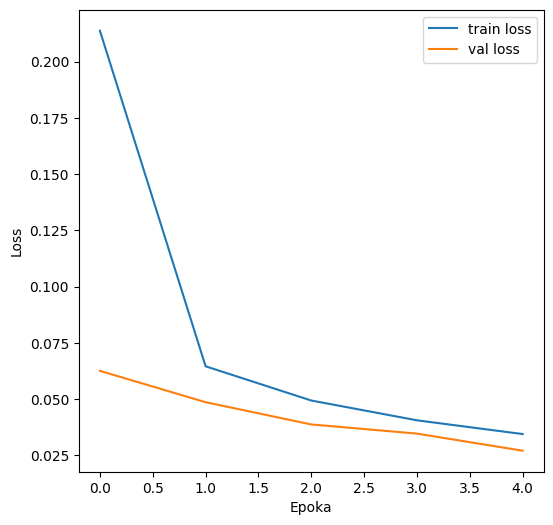

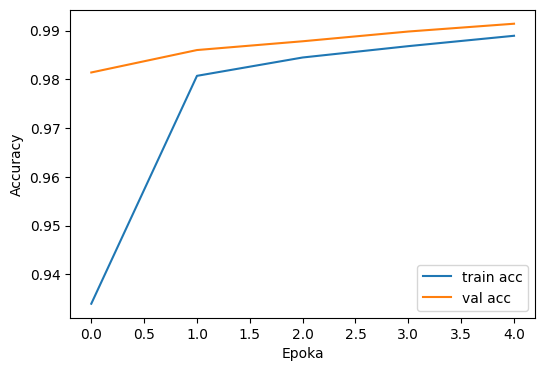

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5, device=device)
plot_history(history)

W porównaniu do Baseline ten model ma lepsze osiągnięcia: większe accuracy i mniejszy loss, dobrze to widać dla walidacji na wykresie(96.9% -> 99.1%; 0.945% -> 0.271%)

#Eksperymenty z wartościami

Następnym krokiem jeszcze chciałbym poeksperymentować z wartościami: węższy i szerszy model o ile to zrozumiałem

Ep 01/5 | train loss 0.3041 acc 0.9069 | val loss 0.0732 acc 0.9802
Ep 02/5 | train loss 0.0868 acc 0.9742 | val loss 0.0566 acc 0.9834
Ep 03/5 | train loss 0.0657 acc 0.9797 | val loss 0.0454 acc 0.9878
Ep 04/5 | train loss 0.0543 acc 0.9831 | val loss 0.0412 acc 0.9870
Ep 05/5 | train loss 0.0469 acc 0.9849 | val loss 0.0448 acc 0.9882
Czas treningu: 181.6s


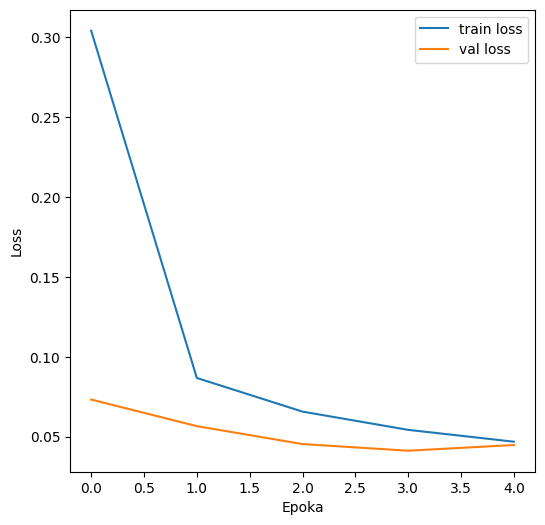

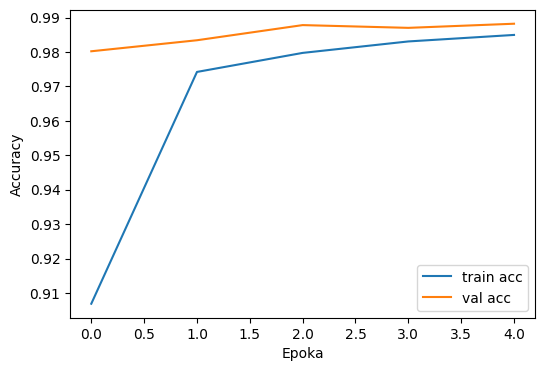

In [40]:
#węższy model?
model = FlexibleCNN(c1=16, c2=32, hidden=64, dropout=0.2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5, device=device)
plot_history(history)

Ep 01/5 | train loss 0.1947 acc 0.9386 | val loss 0.0603 acc 0.9820
Ep 02/5 | train loss 0.0767 acc 0.9759 | val loss 0.0386 acc 0.9892
Ep 03/5 | train loss 0.0600 acc 0.9811 | val loss 0.0334 acc 0.9902
Ep 04/5 | train loss 0.0526 acc 0.9838 | val loss 0.0344 acc 0.9900
Ep 05/5 | train loss 0.0459 acc 0.9854 | val loss 0.0325 acc 0.9908
Czas treningu: 945.8s


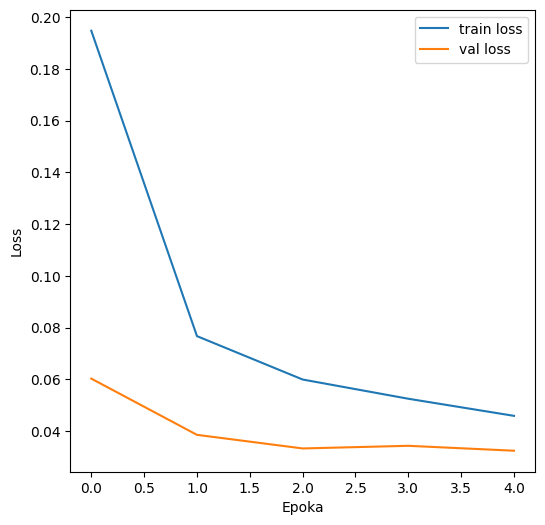

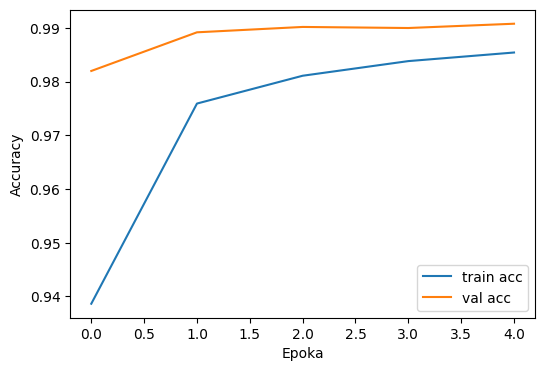

In [41]:
#szerszy model?
model = FlexibleCNN(c1=64, c2=128, hidden=256, dropout=0.5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5, device=device)
plot_history(history)

Modele pokazują wzrost accuracy i zmniejszenie loss wraz z zwiększeniem szerokości modelu. Dla modelu wąskiego początkowy loss był najwyższy w tym czasie jak dla szerokiego on był najmniejszy. Szeroki model ma lepszy start ale wzrost accuracy nie jest na tyle wysoki żeby zamieniać standartny model na szeroki

Może ktoś tego nie zobaczył ale został zmieniony dropout dla wąskiego i szerokiego modelu 0.2 i 0.5 odpowiednio żeby uniknąć underfitting i overfitting w modelach. Teraz sprawdzę jak by to wyglądało dramatycznie zmieniając dropout dla obu modeli

Ep 01/5 | train loss 0.4898 acc 0.8457 | val loss 0.1137 acc 0.9660
Ep 02/5 | train loss 0.2152 acc 0.9371 | val loss 0.0782 acc 0.9768
Ep 03/5 | train loss 0.1741 acc 0.9484 | val loss 0.0648 acc 0.9810
Ep 04/5 | train loss 0.1467 acc 0.9555 | val loss 0.0581 acc 0.9840
Ep 05/5 | train loss 0.1359 acc 0.9597 | val loss 0.0522 acc 0.9862
Czas treningu: 186.0s


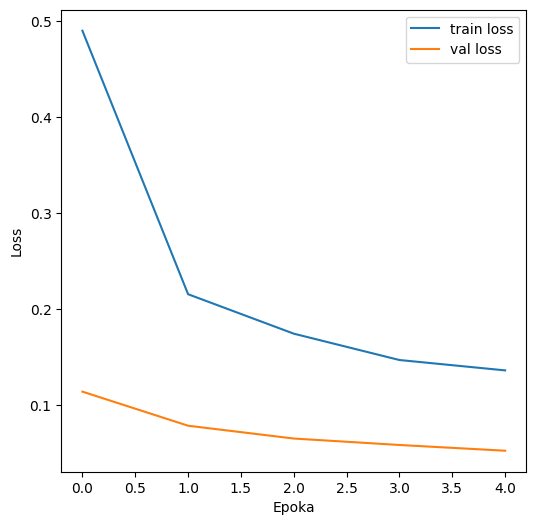

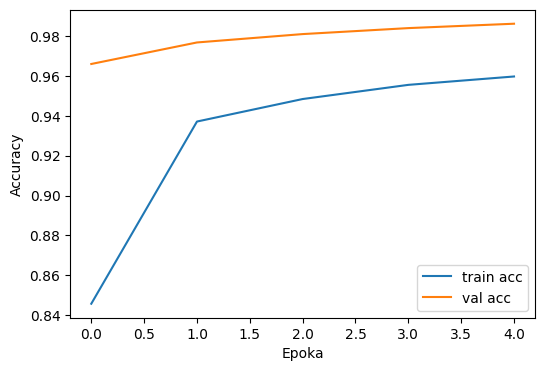

In [51]:
model = FlexibleCNN(c1=16, c2=32, hidden=64, dropout=0.5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5, device=device)
plot_history(history)

Ep 01/5 | train loss 0.1413 acc 0.9564 | val loss 0.0602 acc 0.9806
Ep 02/5 | train loss 0.0429 acc 0.9866 | val loss 0.0430 acc 0.9880
Ep 03/5 | train loss 0.0304 acc 0.9905 | val loss 0.0346 acc 0.9894
Ep 04/5 | train loss 0.0225 acc 0.9930 | val loss 0.0341 acc 0.9892
Ep 05/5 | train loss 0.0162 acc 0.9949 | val loss 0.0290 acc 0.9912
Czas treningu: 922.0s


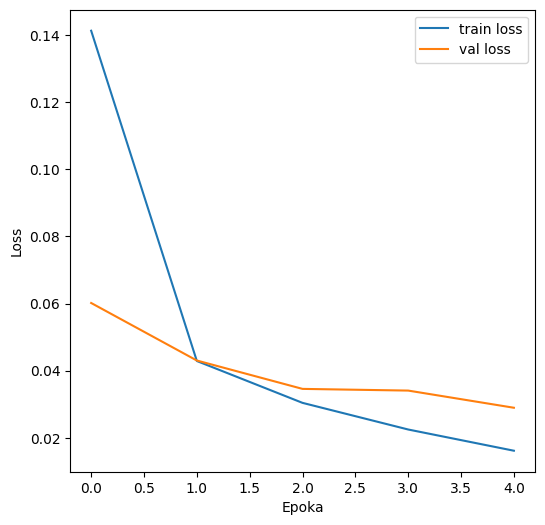

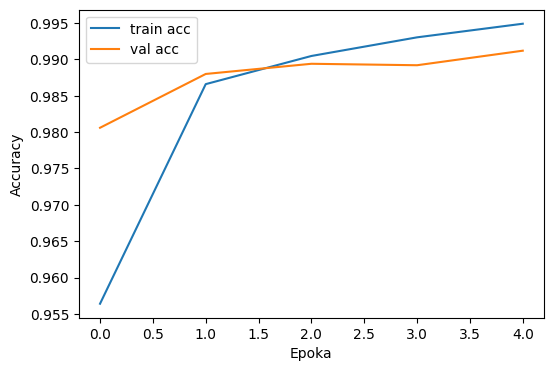

In [45]:
model = FlexibleCNN(c1=64, c2=128, hidden=256, dropout=0.1).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5, device=device)
plot_history(history)

Na szerokim modelu widać wzrost val loss nad train loss i wzrost train acc nad val acc, jakie może znaczyć o overfitting w porównaniu z oryginalem. Dla wąskiego modelu widać jak żle poszedł trening dla modelu: wyższy loss, niższy accuracy. Związane to jest z tym że szeroki model ma dużo parametrów, a razem z tym więcej możliwości do zapamiętania i nauczenia się, dlatego ograniczamy go wysokim dropout, w porównaniu do wąskiego modelu, ograniczenie którego grozi się underfitting.

Dalej sprobuje dodać i zobaczyć jak wpływa BatchNorm na model

In [46]:
class CNNWithBatchNorm(nn.Module):
    def __init__(self, num_classes=10, c1=32, c2=64, hidden=128, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv2d(1, c1, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(c1)
        self.conv2 = nn.Conv2d(c1, c2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(c2)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)

        self.fc1 = nn.Linear(c2 * 7 * 7, hidden)
        self.bn3 = nn.BatchNorm1d(hidden)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Ep 01/5 | train loss 0.1703 acc 0.9612 | val loss 0.0558 acc 0.9842
Ep 02/5 | train loss 0.0552 acc 0.9843 | val loss 0.0372 acc 0.9894
Ep 03/5 | train loss 0.0427 acc 0.9870 | val loss 0.0345 acc 0.9894
Ep 04/5 | train loss 0.0334 acc 0.9900 | val loss 0.0325 acc 0.9886
Ep 05/5 | train loss 0.0289 acc 0.9909 | val loss 0.0337 acc 0.9906
Czas treningu: 418.8s


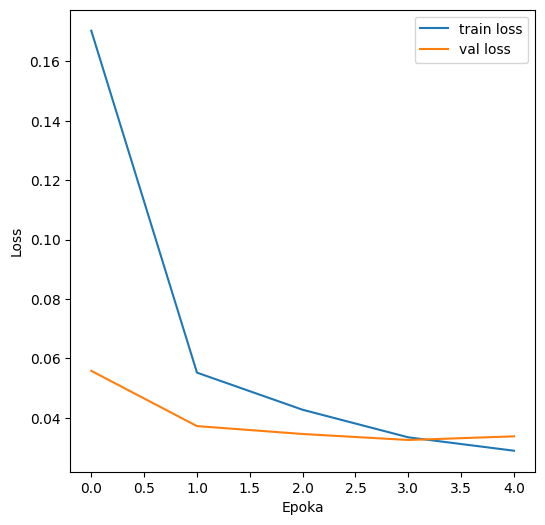

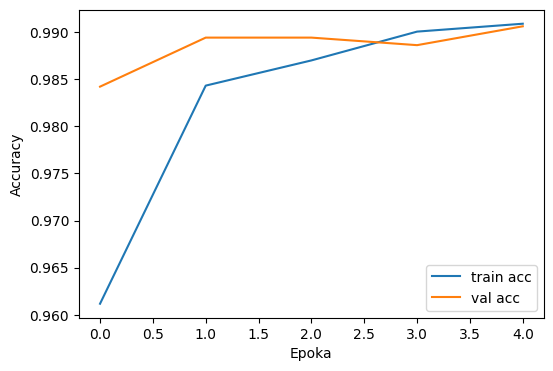

In [47]:
model = CNNWithBatchNorm(c1=32, c2=64, hidden=128, dropout=0.25).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5, device=device)
plot_history(history)

Dopiero to najlepsze wyniki ze wszystkich modeli: 99% na train i val accuracy i małe loss (0.29% i 0.34%)

Dodamy jeszcze do modeli jedną warstwę

In [48]:
class DeeperCNN(nn.Module):
    def __init__(self, num_classes=10, c1=16, c2=32, c3=64, hidden=128, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv2d(1, c1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(c1, c2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(c2, c3, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)

        self.fc1 = nn.Linear(c3 * 3 * 3, hidden)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


Ep 01/5 | train loss 0.3152 acc 0.8992 | val loss 0.0767 acc 0.9778
Ep 02/5 | train loss 0.0840 acc 0.9744 | val loss 0.0583 acc 0.9826
Ep 03/5 | train loss 0.0626 acc 0.9804 | val loss 0.0413 acc 0.9876
Ep 04/5 | train loss 0.0501 acc 0.9845 | val loss 0.0348 acc 0.9884
Ep 05/5 | train loss 0.0417 acc 0.9868 | val loss 0.0346 acc 0.9910
Czas treningu: 205.8s


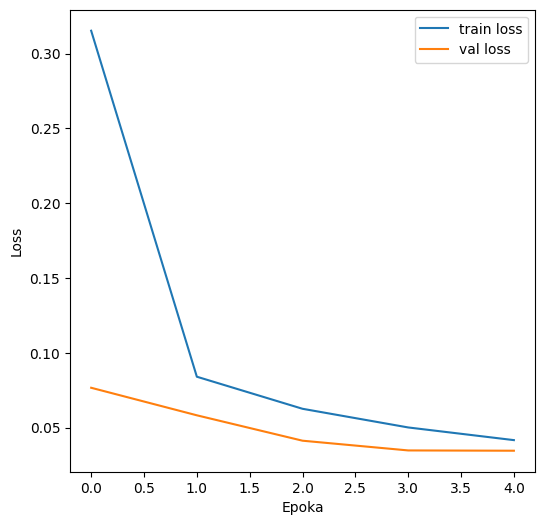

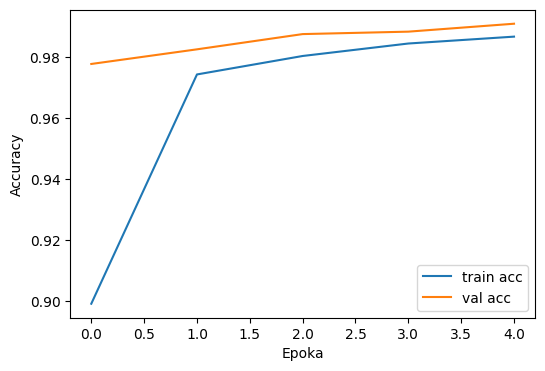

In [49]:
model = DeeperCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5, device=device)
plot_history(history)

Porównując ten głębszy model z pierwszym szerokim modelem (model = FlexibleCNN(c1=64, c2=128, hidden=256, dropout=0.5).to(device)
) doszedłem do wniosku że głębokość wygrywa w tym razie bo osiąga tej samej accuracy i loss jak i dla szerszej modeli ale w krótszym czasie

We wnioskach chciałbym dodać o ważności dobrania dropout do odpowiedniej szerokości modelu żeby uniknąć over albo underfitting. Ciekawe wyszło, że głębokość dała taki samy wynik ale w mniejszym czasie niż szeroki model, związane to może być z tym że szeroki model ma do obliczenia większe macierzy z większą ilością parametrów i dlatego potrzebuje więcej czasu